In [1]:
# Importa bibliotecas necessárias

import html
import pandas as pd
import geopandas as gpd
import os
from math import ceil

In [23]:
from playsound import playsound

In [2]:
# Entra no diretório de dados

os.chdir('C:\\Users\\rgarcia\\Documents\\Code\\2Turno')

In [7]:
# Retira lista de nomes de candidatos a presidente

cands = pd.read_json('https://resultados.tse.jus.br/oficial/ele2022/546/dados/sp/sp-c0003-e000546-006-f.json').loc['agr', 'carg']
cand_nums = pd.json_normalize(pd.json_normalize(pd.json_normalize(pd.json_normalize(pd.json_normalize(cands, max_level=0)['par'])[0])['cand'])[0])
cand_nums = cand_nums[['n', 'nmu']].dropna()
cand_nums['nmu'] = cand_nums.nmu.apply(lambda x: html.unescape(x).title())
cand_dict = dict(zip(cand_nums.n.to_list(), cand_nums.nmu.to_list()))

In [18]:
sorted(list(cand_dict.keys()))

['10', '12', '13', '16', '21', '27', '29', '30', '45', '80']

In [9]:
# Gera lista de códigos de municipios para injetar no JSON

cod_mun = pd.read_csv('https://raw.githubusercontent.com/rafagarc/eleicoes_2022/main/mapas_1o_turno/codigos_IBGE_TSE.csv')
cod_mun['codigo_tse'] = cod_mun.codigo_tse.astype(str).str.zfill(5)
muns = cod_mun.codigo_tse.to_list()
cod_mun['uf'] = cod_mun.uf.str.lower()
list_mun = cod_mun['uf'].astype(str) + cod_mun['codigo_tse'].astype(str).to_list()

In [12]:
list_mun = [i for i in list_mun if 'sp' in i]

In [28]:
# Gera chassi para concatenar a tabela
munvotes = pd.DataFrame(columns=['muncod', '10', '12', '13', '16', '21', '27', '29', '30', '45', '80'])

# Captura JSON com votação por município, linha a linha
for i in list_mun:
    raw_data = pd.read_json(f'https://resultados.tse.jus.br/oficial/ele2022/546/dados/sp/{i}-c0003-e000546-v.json')
    raw_mun = pd.json_normalize(raw_data['abr']).query('tpabr == "MU"')['cand']
    mun = pd.json_normalize(pd.json_normalize(raw_mun).T[0])
    mun = mun[['n', 'vap']].T
    mun.columns = mun.loc['n']
    mun = mun.drop('n')
    mun.insert(loc=0, column='muncod', value=[i])
    munvotes = pd.concat([munvotes,mun])

# Substitui números por nomes dos candidatos nas colunas
munvotes.columns = [cand_dict[i] if i in cand_dict.keys() else i for i in munvotes.columns]

In [29]:
munvotes

,muncod,Tarcísio,Elvis Cezar,Fernando Haddad,Altino,Gabriel Colombo,Antonio Jorge,Edson Dorta,Vinicius Poit,Rodrigo Garcia,Carol Vigliar
vap,sp61018,11940,104,3337,7,23,5,5,149,2496,25
vap,sp61034,1353,12,561,0,1,0,0,5,956,2
vap,sp61050,6903,94,4396,7,32,2,2,102,3572,25
vap,sp61131,9896,122,4377,5,25,4,0,219,5508,38
vap,sp61581,1538,13,810,0,2,0,0,10,1158,0
...,...,...,...,...,...,...,...,...,...,...,...
vap,sp61115,1529,12,724,3,7,1,2,31,628,5
vap,sp61239,1291,4,569,1,5,0,0,9,731,2
vap,sp61255,5792,42,3360,2,9,2,3,60,3909,24
vap,sp61271,650,23,629,0,3,0,0,4,634,2


In [30]:
# Opção de salvar o dataframe de 1o turno ou recarregá-lo

# munvotes.to_csv('munvotes_gov_1t.csv', index=False)

# munvotes = pd.read_csv('munvotes_gov_1t.csv')

In [31]:
# Cria dataframe com votações percentuais

munvotes = munvotes.set_index('muncod')
munvotes = munvotes.astype('int32')
munvotes['TOTAL'] = munvotes.sum(axis=1)
munvotes_pct = (munvotes.drop(columns='TOTAL').div(munvotes.TOTAL, axis=0)*100).round(2)
munvotes_pct['Tarcisio - Haddad (%)'] = (munvotes_pct['Tarcísio']-munvotes_pct['Fernando Haddad']).round(2)
munvotes_pct['Votos válidos'] = munvotes.TOTAL

In [33]:
# Cria uma série com os códigos TSE sem zero à esquerda e insere no dataframe

tse_codes = munvotes_pct.index.to_series().apply(lambda x: int(x[-5:]))
munvotes_pct.insert(loc=0, column='codigo_tse', value=tse_codes)

In [37]:
# Carrega conversor de códigos TSE para IBGE e ajusta em colunas no dataframe

tse_ibge = pd.read_csv('https://raw.githubusercontent.com/rafagarc/eleicoes_2022/main/mapas_1o_turno/codigos_IBGE_TSE.csv')
munvotes_agg = tse_ibge.merge(munvotes_pct, how='left', on='codigo_tse')
munvotes_agg['codigo_ibge'] = munvotes_agg.codigo_ibge.astype(str)

In [38]:
# Carrega o mapa de municípios e funde com a tabela de votação 

munmap = gpd.read_file('C:\\Users\\rgarcia\\Documents\\Data\\BR_Municipios_2021_low_res.json')
munmap = munmap.rename(columns={'CD_MUN':'codigo_ibge'})
votemap = munmap.merge(munvotes_agg, on='codigo_ibge', how='left')

In [39]:
# Determina os limites para legenda do plot do Geopandas

legbound = ceil(max((votemap['Tarcisio - Haddad (%)'].min()*-1, votemap['Tarcisio - Haddad (%)'].max())))

<AxesSubplot:>

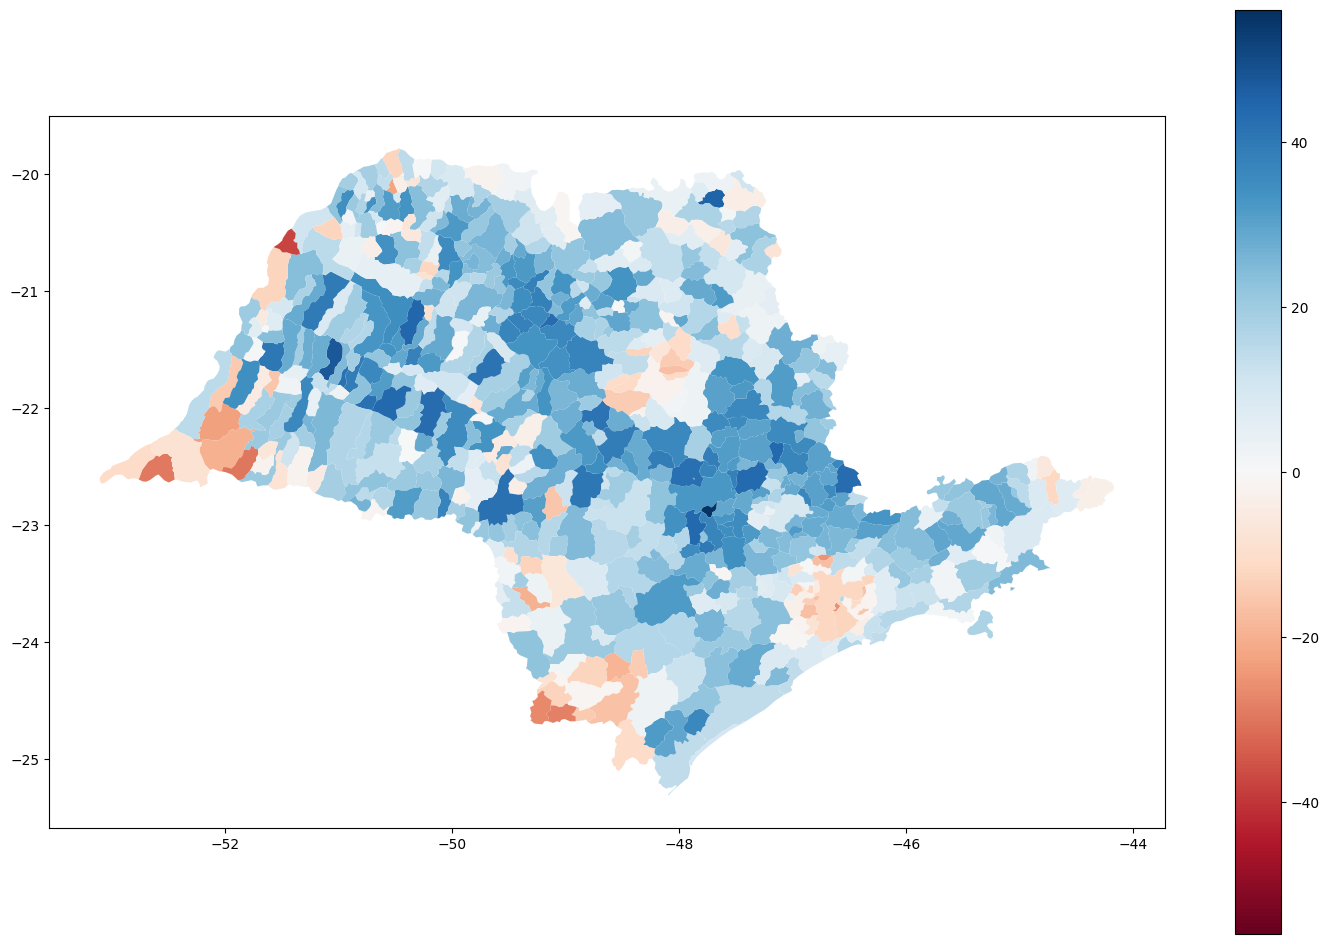

In [41]:
# Plota o mapa de votação 1º turno

votemap.plot(figsize=(18,12), column='Tarcisio - Haddad (%)', cmap='RdBu', legend=True, vmin=-legbound, vmax=legbound)

In [12]:
# AGORA O SEGUNDO TURNO

In [13]:
# Gera chassi para concatenar a tabela

munvotes2 = pd.DataFrame(columns=['muncod', '13', '22'])

# Captura JSON com votação por município, linha a linha

for i in list_mun:
    raw_data2 = pd.read_json(f'https://resultados.tse.jus.br/oficial/ele2022/545/dados/{i[0:2]}/{i}-c0001-e000545-v.json')
    raw_mun2 = pd.json_normalize(raw_data2['abr']).query('tpabr == "MU"')['cand']
    mun2 = pd.json_normalize(pd.json_normalize(raw_mun2).T[0])
    mun2 = mun2[['n', 'vap']].T
    mun2.columns = mun2.loc['n']
    mun2 = mun2.drop('n')
    mun2.insert(loc=0, column='muncod', value=[i])
    munvotes2 = pd.concat([munvotes2,mun2])

# Substitui números por nomes dos candidatos nas colunas
munvotes2.columns = [cand_dict[i] if i in cand_dict.keys() else i for i in munvotes2.columns]

KeyboardInterrupt: 

In [14]:
# Opção de salvar ou recarregar a tabela

# munvotes2.to_csv('munvotes_pres_2t.csv', index=False)
# munvotes2 = pd.read_csv('munvotes_pres_2t.csv')

In [15]:
# Cria tabela com percentual de votação

munvotes2 = munvotes2.set_index('muncod')
munvotes2 = munvotes2.astype('int32')
munvotes2['TOTAL'] = munvotes2.sum(axis=1)
munvotes2_pct = (munvotes2.drop(columns='TOTAL').div(munvotes2.TOTAL, axis=0)*100).round(2)
munvotes2_pct['Bolsonaro - Lula (%)'] = (munvotes2_pct['Jair Bolsonaro']-munvotes2_pct['Lula']).round(2)
munvotes2_pct['Votos válidos'] = munvotes2.TOTAL
munvotes2_pct = munvotes2_pct.fillna(0)

In [26]:
# Emparelha as duas tabelas e retira candidatos que perderam no 1º turno

t1_vs_t2 = munvotes_pct.merge (munvotes2_pct.reset_index(), how='left', on='muncod')

t1_vs_t2 = t1_vs_t2.drop(columns=['Padre Kelmon', 'Sofia Manzano',
       'Constituinte Eymael', 'Soraya Thronicke', 'Ciro Gomes', 'Vera',
       'Simone Tebet', 'Felipe D\'Avila', 'Léo Péricles'])

In [27]:
t1_vs_t2

,muncod,codigo_tse,Lula_x,Jair Bolsonaro_x,Bolsonaro - Lula (%)_x,Votos válidos_x,Lula_y,Jair Bolsonaro_y,Bolsonaro - Lula (%)_y,Votos válidos_y
0,ac01120,1120,21.30,73.59,52.29,7118,0.0,0.0,0.0,0
1,ac01570,1570,41.12,55.31,14.19,4871,0.0,0.0,0.0,0
2,ac01058,1058,29.50,64.67,35.17,14138,0.0,0.0,0.0,0
3,ac01007,1007,29.33,62.03,32.70,7263,0.0,0.0,0.0,0
4,ac01015,1015,27.12,65.61,38.49,6011,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
5565,to96199,96199,71.39,25.89,-45.50,3998,0.0,0.0,0.0,0
5566,to73458,73458,60.18,35.31,-24.87,1464,0.0,0.0,0.0,0
5567,to73237,73237,64.84,29.24,-35.60,1385,0.0,0.0,0.0,0
5568,to96652,96652,60.01,35.56,-24.45,5296,0.0,0.0,0.0,0


In [28]:
munmap.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5570 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   codigo_ibge  5570 non-null   object  
 1   NM_MUN       5570 non-null   object  
 2   SIGLA        5570 non-null   object  
 3   geometry     5570 non-null   geometry
 4   codigo_tse   5570 non-null   int32   
dtypes: geometry(1), int32(1), object(3)
memory usage: 239.3+ KB


In [29]:
cod_mun['codigo_tse'] = cod_mun.codigo_tse.astype(int)
cod_mun['codigo_ibge'] = cod_mun.codigo_ibge.astype(str)

In [30]:
munmap = munmap[['codigo_ibge', 'NM_MUN', 'SIGLA', 'geometry']].merge(cod_mun[['codigo_ibge', 'codigo_tse']], how='left', on='codigo_ibge')

In [31]:
munmap = munmap[~munmap.codigo_tse.isna()]

In [32]:
munmap['codigo_tse'] = munmap.codigo_tse.astype(int)

In [33]:
t1_vs_t2 = munmap.merge(t1_vs_t2, on='codigo_tse', how='left')

In [38]:
t1_vs_t2 = t1_vs_t2.drop(columns='muncod')

In [42]:
t1_vs_t2.columns = [i.replace('_x', '_T1').replace('_y', '_T2') for i in t1_vs_t2.columns]

In [49]:
t1_vs_t2['Avanco_Lula'] = (t1_vs_t2.Lula_T2 - t1_vs_t2.Lula_T1).round(2)

In [51]:
t1_vs_t2['Avanco_Bolsonaro'] = (t1_vs_t2['Jair Bolsonaro_T2'] - t1_vs_t2['Jair Bolsonaro_T1']).round(2)

In [58]:
t1_vs_t2['vencedor_t1'] = t1_vs_t2[['Lula_T1', 'Jair Bolsonaro_T1']].idxmax(axis=1).str.replace('_T1', '')

In [62]:
t1_vs_t2['vencedor_t2'] = t1_vs_t2[['Lula_T2', 'Jair Bolsonaro_T2']].idxmax(axis=1).str.replace('_T2', '')

In [65]:
t1_vs_t2['virada'] = t1_vs_t2.vencedor_t1 != t1_vs_t2.vencedor_t2

In [71]:
viradas_lula = t1_vs_t2[t1_vs_t2.virada & (t1_vs_t2.vencedor_t2 == "Lula")].reset_index()

In [ ]:
viradas_bolsonaro = t1_vs_t2[t1_vs_t2.virada & (t1_vs_t2.vencedor_t2 == "Bolsonaro")].reset_index()